<a href="https://colab.research.google.com/github/JoJa171199/INESDI_Data-Science_ML_IA/blob/main/%5B06%5D%20-%20Deep%20Learning/LSTM_ventas_futuras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎯 Caso Práctico: LSTM


---

## 📋 Información del Módulo

**Asignatura:** Data Analytics: Data Science, Machine Learning e Inteligencia Artificial  
**Máster:** FP en Business Analytics e Inteligencia Artificial  
**Profesores:** Álvaro López Barberá
**Ejemplo Práctico:**  Deep Learning (LSTM)

---

## 🎓 Objetivo

Desarrollar un modelo LSTM para predecir ventas futuras, permitiendo:
** Forecasting de ingresos
** Optimización de inventario
Planificación de campañas
Budget allocation inteligente

**Dataset:** FER-2013 (Facial Expression Recognition)  
**7 Emociones:** Enojado, Disgustado, Asustado, Feliz, Triste, Sorprendido, Neutral


---

## 📦 PASO 1: Instalación y Configuración Inicial

In [1]:
print("📦 Configurando entorno...")

# Imports principales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# TensorFlow y Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Sklearn para preprocesamiento
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 6)

print(f"✅ TensorFlow: {tf.__version__}")
print(f"✅ GPU disponible: {len(tf.config.list_physical_devices('GPU')) > 0}")
print("✅ Librerías cargadas correctamente\n")

📦 Configurando entorno...
✅ TensorFlow: 2.19.0
✅ GPU disponible: False
✅ Librerías cargadas correctamente



---

## 📊 PASO 2: Generacion de serie temporal

In [2]:
print("=" * 80)
print("PASO 2: GENERACIÓN DE SERIE TEMPORAL SINTÉTICA")
print("=" * 80)

def generar_datos_ventas(n_days=1095, seed=42):
    """
    Genera serie temporal sintética de ventas con:
    - Tendencia creciente
    - Estacionalidad semanal
    - Estacionalidad anual
    - Eventos especiales (Black Friday, Navidad)
    - Ruido aleatorio
    """
    np.random.seed(seed)

    # Fechas
    start_date = datetime(2021, 1, 1)
    dates = [start_date + timedelta(days=i) for i in range(n_days)]

    # Componentes de la serie
    t = np.arange(n_days)

    # 1. Tendencia creciente
    trend = 10000 + (t * 5)

    # 2. Estacionalidad semanal
    weekly_seasonality = 1000 * np.sin(2 * np.pi * t / 7)

    # 3. Estacionalidad anual
    annual_seasonality = 2000 * np.sin(2 * np.pi * t / 365.25 - np.pi/2)

    # 4. Eventos especiales
    events = np.zeros(n_days)
    for year in [2021, 2022, 2023]:
        # Black Friday
        bf_date = datetime(year, 11, 25)
        bf_idx = (bf_date - start_date).days
        if 0 <= bf_idx < n_days:
            events[bf_idx:bf_idx+3] = 5000

        # Navidad
        xmas_date = datetime(year, 12, 20)
        xmas_idx = (xmas_date - start_date).days
        if 0 <= xmas_idx < n_days:
            events[xmas_idx:xmas_idx+7] = 3000

    # 5. Ruido
    noise = np.random.normal(0, 500, n_days)

    # Combinar
    sales = trend + weekly_seasonality + annual_seasonality + events + noise
    sales = np.maximum(sales, 0)

    # DataFrame
    df = pd.DataFrame({
        'fecha': dates,
        'ventas': sales
    })

    df['dia_semana'] = df['fecha'].dt.dayofweek
    df['mes'] = df['fecha'].dt.month
    df['año'] = df['fecha'].dt.year

    return df

# Generar datos
print("\n📈 Generando serie temporal de ventas...")
df = generar_datos_ventas(n_days=1095)

print(f"\n✅ Datos generados:")
print(f"   • Período: {df['fecha'].min().date()} a {df['fecha'].max().date()}")
print(f"   • Total días: {len(df)}")
print(f"   • Ventas promedio: ${df['ventas'].mean():,.2f}")
print(f"   • Ventas mínimas: ${df['ventas'].min():,.2f}")
print(f"   • Ventas máximas: ${df['ventas'].max():,.2f}")

PASO 2: GENERACIÓN DE SERIE TEMPORAL SINTÉTICA

📈 Generando serie temporal de ventas...

✅ Datos generados:
   • Período: 2021-01-01 a 2023-12-31
   • Total días: 1095
   • Ventas promedio: $12,853.08
   • Ventas mínimas: $6,376.33
   • Ventas máximas: $19,750.73


---

## 🔧 PASO 3: Visualización de la serie

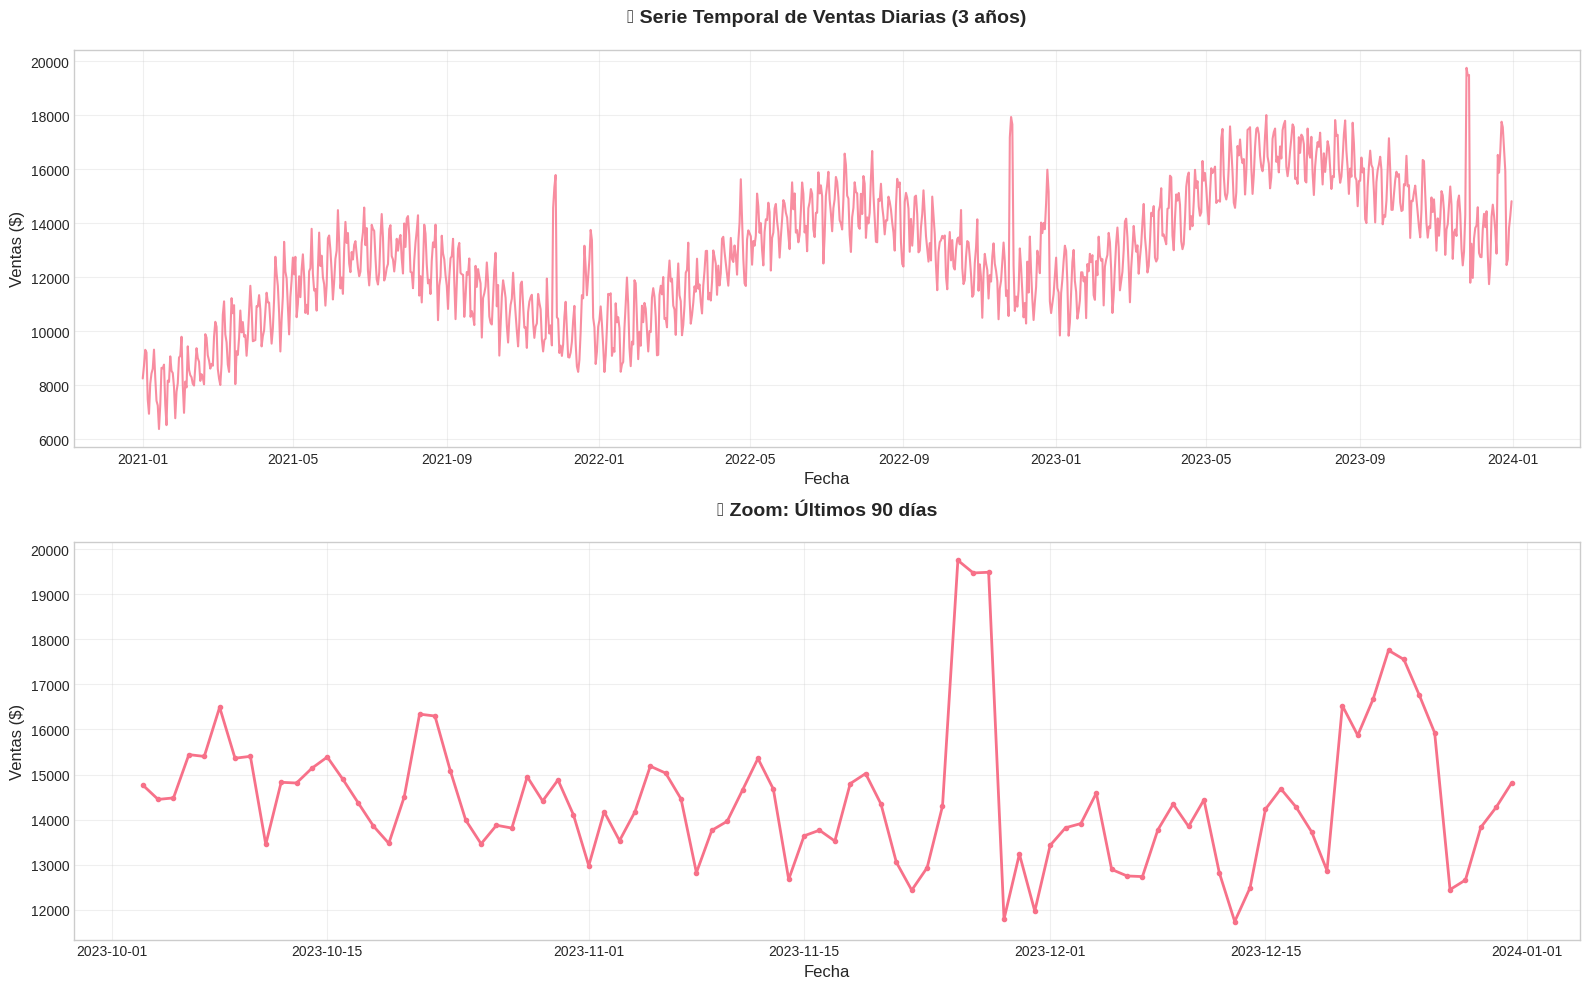


💡 Observa la tendencia creciente y patrones repetitivos


In [3]:
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Serie completa
axes[0].plot(df['fecha'], df['ventas'], linewidth=1.5, alpha=0.8)
axes[0].set_title('📈 Serie Temporal de Ventas Diarias (3 años)',
                  fontsize=14, fontweight='bold', pad=20)
axes[0].set_xlabel('Fecha', fontsize=12)
axes[0].set_ylabel('Ventas ($)', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Zoom últimos 90 días
df_recent = df.tail(90)
axes[1].plot(df_recent['fecha'], df_recent['ventas'],
             linewidth=2, marker='o', markersize=3)
axes[1].set_title('🔍 Zoom: Últimos 90 días',
                  fontsize=14, fontweight='bold', pad=20)
axes[1].set_xlabel('Fecha', fontsize=12)
axes[1].set_ylabel('Ventas ($)', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Observa la tendencia creciente y patrones repetitivos")

---

## 🔧 PASO 4: Análisis Exploratorio


PASO 4: ANÁLISIS EXPLORATORIO

📊 Estadísticas Descriptivas:
count     1095.000000
mean     12853.082264
std       2357.451749
min       6376.331369
25%      11256.002799
50%      12841.120423
75%      14539.510488
max      19750.727746
Name: ventas, dtype: float64


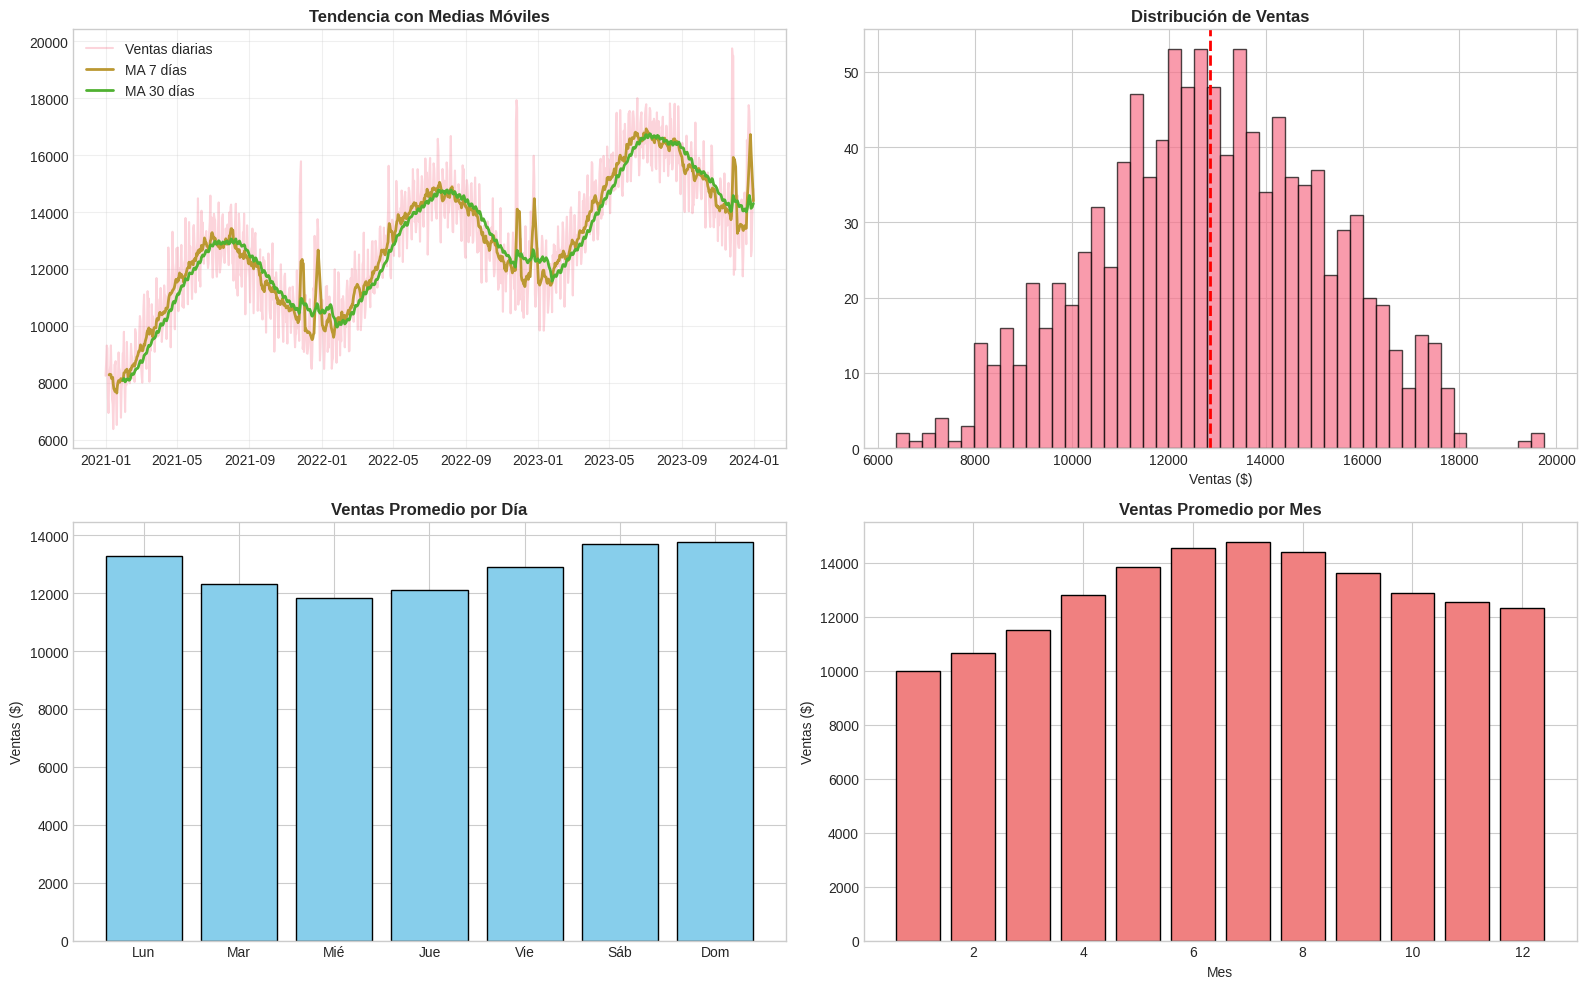


💡 Insights: Fines de semana venden más, picos en Nov/Dic


In [4]:
print("\n" + "=" * 80)
print("PASO 4: ANÁLISIS EXPLORATORIO")
print("=" * 80)

# Estadísticas
print("\n📊 Estadísticas Descriptivas:")
print(df['ventas'].describe())

# Medias móviles
df['ma_7'] = df['ventas'].rolling(window=7).mean()
df['ma_30'] = df['ventas'].rolling(window=30).mean()

# Visualización
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Tendencia
axes[0, 0].plot(df['fecha'], df['ventas'], alpha=0.3, label='Ventas diarias')
axes[0, 0].plot(df['fecha'], df['ma_7'], linewidth=2, label='MA 7 días')
axes[0, 0].plot(df['fecha'], df['ma_30'], linewidth=2, label='MA 30 días')
axes[0, 0].set_title('Tendencia con Medias Móviles', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Histograma
axes[0, 1].hist(df['ventas'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(df['ventas'].mean(), color='red', linestyle='--', linewidth=2)
axes[0, 1].set_title('Distribución de Ventas', fontweight='bold')
axes[0, 1].set_xlabel('Ventas ($)')

# Por día de semana
dias = ['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom']
ventas_dia = df.groupby('dia_semana')['ventas'].mean()
axes[1, 0].bar(range(7), ventas_dia, color='skyblue', edgecolor='black')
axes[1, 0].set_xticks(range(7))
axes[1, 0].set_xticklabels(dias)
axes[1, 0].set_title('Ventas Promedio por Día', fontweight='bold')
axes[1, 0].set_ylabel('Ventas ($)')

# Por mes
ventas_mes = df.groupby('mes')['ventas'].mean()
axes[1, 1].bar(range(1, 13), ventas_mes, color='lightcoral', edgecolor='black')
axes[1, 1].set_title('Ventas Promedio por Mes', fontweight='bold')
axes[1, 1].set_xlabel('Mes')
axes[1, 1].set_ylabel('Ventas ($)')

plt.tight_layout()
plt.show()

print("\n💡 Insights: Fines de semana venden más, picos en Nov/Dic")

---

## 🔧 PASO 5: Preparación de datos para LSTM

In [5]:
print("\n" + "=" * 80)
print("PASO 5: PREPARACIÓN DE DATOS PARA LSTM")
print("=" * 80)

# Extraer ventas como array
data = df['ventas'].values.reshape(-1, 1)
print(f"\n📊 Shape original: {data.shape}")

# Normalización
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

print(f"\n✅ Normalización completada:")
print(f"   • Rango original: ${data.min():.2f} - ${data.max():.2f}")
print(f"   • Rango normalizado: {data_scaled.min():.4f} - {data_scaled.max():.4f}")

# Crear secuencias
def crear_secuencias(data, lookback=60):
    """
    Crea secuencias de entrada (X) y salida (y) para LSTM
    """
    X, y = [], []

    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, 0])
        y.append(data[i, 0])

    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)

    return X, y

LOOKBACK = 60
print(f"\n🔄 Creando secuencias con ventana de {LOOKBACK} días...")
X, y = crear_secuencias(data_scaled, lookback=LOOKBACK)

print(f"\n✅ Secuencias creadas:")
print(f"   • Shape X: {X.shape} (samples, timesteps, features)")
print(f"   • Shape y: {y.shape}")

# División temporal
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

X_train = X[:train_size]
y_train = y[:train_size]
X_val = X[train_size:train_size+val_size]
y_val = y[train_size:train_size+val_size]
X_test = X[train_size+val_size:]
y_test = y[train_size+val_size:]

print(f"\n📊 División temporal:")
print(f"   • Train: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"   • Validation: {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")
print(f"   • Test: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")


PASO 5: PREPARACIÓN DE DATOS PARA LSTM

📊 Shape original: (1095, 1)

✅ Normalización completada:
   • Rango original: $6376.33 - $19750.73
   • Rango normalizado: 0.0000 - 1.0000

🔄 Creando secuencias con ventana de 60 días...

✅ Secuencias creadas:
   • Shape X: (1035, 60, 1) (samples, timesteps, features)
   • Shape y: (1035,)

📊 División temporal:
   • Train: 724 (70.0%)
   • Validation: 155 (15.0%)
   • Test: 156 (15.1%)


---

## 🔧 PASO 6: Arquitectura LSTM

In [6]:
print("\n" + "=" * 80)
print("PASO 6: CONSTRUCCIÓN DE ARQUITECTURA LSTM")
print("=" * 80)

def crear_modelo_lstm(lookback, units=[64, 32]):
    """
    Crea modelo LSTM para forecasting
    """
    model = models.Sequential(name='SalesForecastLSTM')

    # Primera capa LSTM
    model.add(layers.LSTM(
        units[0],
        return_sequences=True,
        input_shape=(lookback, 1),
        name='lstm1'
    ))
    model.add(layers.Dropout(0.2))

    # Segunda capa LSTM
    model.add(layers.LSTM(
        units[1],
        return_sequences=False,
        name='lstm2'
    ))
    model.add(layers.Dropout(0.2))

    # Capas densas
    model.add(layers.Dense(25, activation='relu'))
    model.add(layers.Dense(1))

    return model

print("\n🏗️  Construyendo modelo LSTM...\n")
model = crear_modelo_lstm(lookback=LOOKBACK, units=[64, 32])
model.summary()

print(f"\n📊 Total parámetros: {model.count_params():,}")


PASO 6: CONSTRUCCIÓN DE ARQUITECTURA LSTM

🏗️  Construyendo modelo LSTM...



Model: "SalesForecastLSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm1 (LSTM)                    │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm2 (LSTM)                    │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │           825 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,163 (117.82 KB)

 Trainable params: 30,163 (117.82 KB)

 Non-trainable params: 0 (0.00 B)


📊 Total parámetros: 30,163


---

## 🔧 PASO 7: Compilación

In [7]:
print("\n" + "=" * 80)
print("PASO 7: COMPILACIÓN DEL MODELO")
print("=" * 80)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

print("\n✅ Modelo compilado:")
print("   • Optimizer: Adam (lr=0.001)")
print("   • Loss: MSE")
print("   • Métricas: MAE")


PASO 7: COMPILACIÓN DEL MODELO

✅ Modelo compilado:
   • Optimizer: Adam (lr=0.001)
   • Loss: MSE
   • Métricas: MAE


---

## 🔧 PASO 8: Callbacks

In [8]:
print("\n" + "=" * 80)
print("PASO 8: CONFIGURACIÓN DE CALLBACKS")
print("=" * 80)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_lstm_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=0
)

print("\n✅ Callbacks configurados")


PASO 8: CONFIGURACIÓN DE CALLBACKS

✅ Callbacks configurados


---

## 🔧 PASO 9: Entrenamiento

In [9]:
print("\n" + "=" * 80)
print("PASO 9: ENTRENAMIENTO DEL MODELO")
print("=" * 80)

EPOCHS = 50
BATCH_SIZE = 32

print(f"\n🚀 Iniciando entrenamiento...")
print(f"   • Épocas: {EPOCHS}")
print(f"   • Batch size: {BATCH_SIZE}\n")

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

print("\n✅ ENTRENAMIENTO COMPLETADO!")


PASO 9: ENTRENAMIENTO DEL MODELO

🚀 Iniciando entrenamiento...
   • Épocas: 50
   • Batch size: 32

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - loss: 0.0751 - mae: 0.2227 - val_loss: 0.0127 - val_mae: 0.0945 - learning_rate: 0.0010
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0112 - mae: 0.0848 - val_loss: 0.0110 - val_mae: 0.0866 - learning_rate: 0.0010
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0093 - mae: 0.0750 - val_loss: 0.0102 - val_mae: 0.0831 - learning_rate: 0.0010
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0085 - mae: 0.0747 - val_loss: 0.0070 - val_mae: 0.0679 - learning_rate: 0.0010
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0102 - mae: 0.0783 - val_loss: 0.0101 - val_mae: 0.0824 - learning_rate: 0.0010
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.0086 - mae: 0.0737 - val_loss: 0.0052 - val_mae: 0.0600 - learning_rate: 0.0010
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - 

---

## 🔧 PASO 10: Visualización del entrenamiento


PASO 10: ANÁLISIS DEL ENTRENAMIENTO


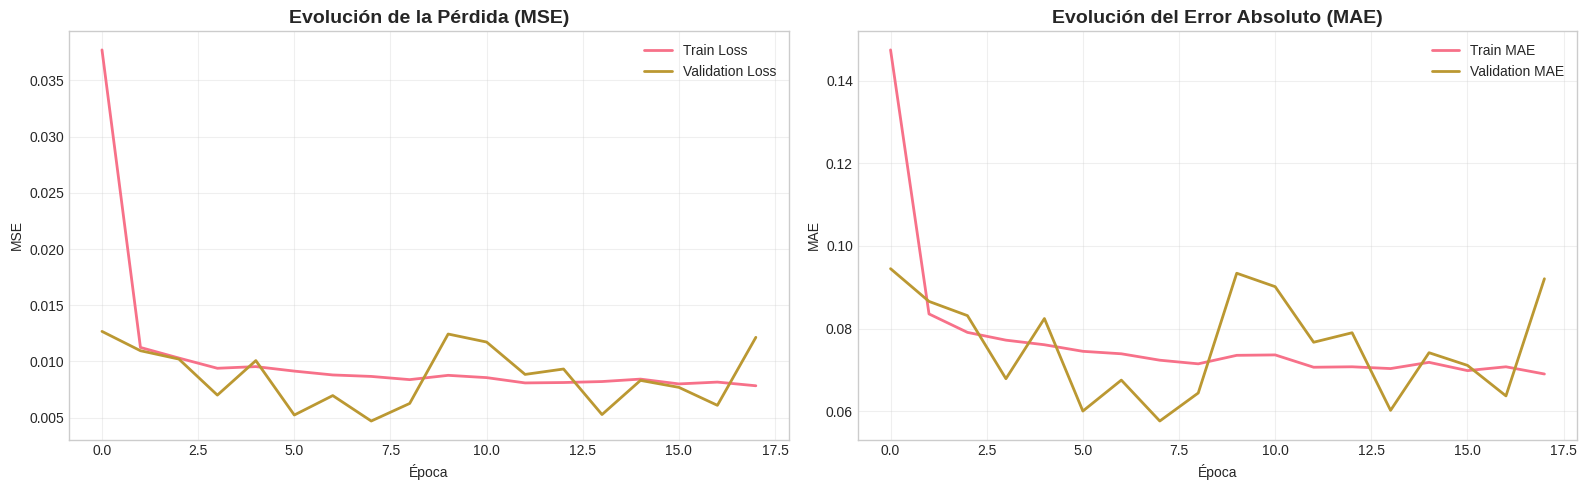

In [10]:
print("\n" + "=" * 80)
print("PASO 10: ANÁLISIS DEL ENTRENAMIENTO")
print("=" * 80)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Loss
axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Evolución de la Pérdida (MSE)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('MSE')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE
axes[1].plot(history.history['mae'], label='Train MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_title('Evolución del Error Absoluto (MAE)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## 🔧 PASO 11: Predicciones y Evaluación

In [11]:
print("\n" + "=" * 80)
print("PASO 11: PREDICCIONES Y EVALUACIÓN")
print("=" * 80)

print("\n🔮 Generando predicciones...")

train_pred = model.predict(X_train, verbose=0)
val_pred = model.predict(X_val, verbose=0)
test_pred = model.predict(X_test, verbose=0)

# Denormalizar
train_pred = scaler.inverse_transform(train_pred)
y_train_original = scaler.inverse_transform(y_train.reshape(-1, 1))

val_pred = scaler.inverse_transform(val_pred)
y_val_original = scaler.inverse_transform(y_val.reshape(-1, 1))

test_pred = scaler.inverse_transform(test_pred)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

print("✅ Predicciones completadas y denormalizadas")


PASO 11: PREDICCIONES Y EVALUACIÓN

🔮 Generando predicciones...
✅ Predicciones completadas y denormalizadas


---

## 🔧 PASO 12: Métricas de Negocio

In [12]:
print("\n" + "=" * 80)
print("PASO 12: MÉTRICAS DE NEGOCIO")
print("=" * 80)

def calcular_metricas(y_true, y_pred, set_name="Test"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print(f"\n📊 Métricas en {set_name}:")
    print(f"   • MAE: ${mae:,.2f}")
    print(f"   • RMSE: ${rmse:,.2f}")
    print(f"   • MAPE: {mape:.2f}%")

    return mae, rmse, mape

train_metrics = calcular_metricas(y_train_original, train_pred, "Train")
val_metrics = calcular_metricas(y_val_original, val_pred, "Validation")
test_metrics = calcular_metricas(y_test_original, test_pred, "Test")

mape_test = test_metrics[2]
print(f"\n💡 MAPE en Test: {mape_test:.2f}%")
if mape_test < 10:
    print("   ✅ EXCELENTE - Modelo muy preciso")
elif mape_test < 20:
    print("   ✓ BUENO - Modelo útil para planificación")
else:
    print("   ⚠️  MEJORABLE - Revisar arquitectura")


PASO 12: MÉTRICAS DE NEGOCIO

📊 Métricas en Train:
   • MAE: $895.30
   • RMSE: $1,145.21
   • MAPE: 7.68%

📊 Métricas en Validation:
   • MAE: $770.65
   • RMSE: $916.31
   • MAPE: 5.02%

📊 Métricas en Test:
   • MAE: $979.53
   • RMSE: $1,355.44
   • MAPE: 6.53%

💡 MAPE en Test: 6.53%
   ✅ EXCELENTE - Modelo muy preciso


---

## 🔧 PASO 13: Visualización de resultados


PASO 13: VISUALIZACIÓN DE RESULTADOS


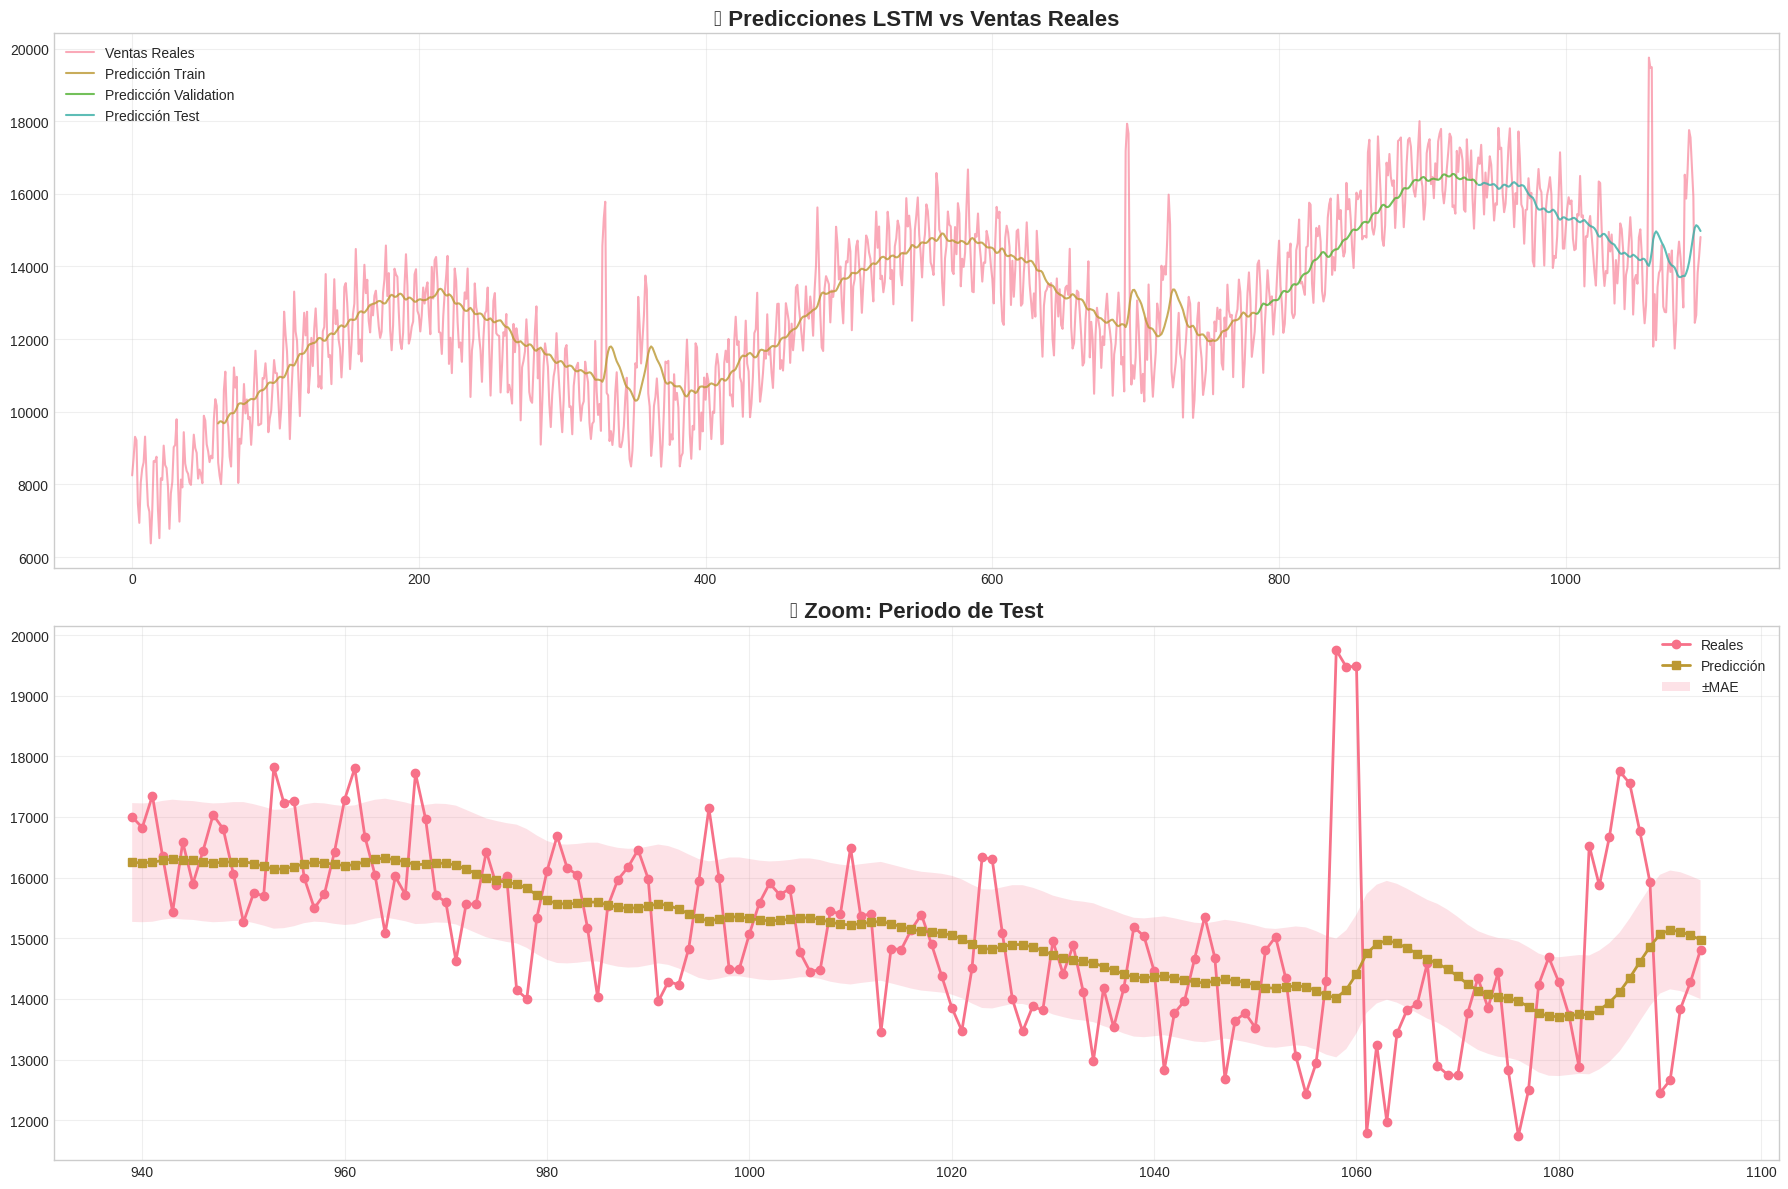

In [13]:
print("\n" + "=" * 80)
print("PASO 13: VISUALIZACIÓN DE RESULTADOS")
print("=" * 80)

# Índices temporales
train_idx = range(LOOKBACK, LOOKBACK + len(train_pred))
val_idx = range(LOOKBACK + len(train_pred), LOOKBACK + len(train_pred) + len(val_pred))
test_idx = range(LOOKBACK + len(train_pred) + len(val_pred),
                 LOOKBACK + len(train_pred) + len(val_pred) + len(test_pred))

fig, axes = plt.subplots(2, 1, figsize=(18, 12))

# Serie completa
axes[0].plot(df.index, df['ventas'], label='Ventas Reales', alpha=0.6, linewidth=1.5)
axes[0].plot(train_idx, train_pred, label='Predicción Train', alpha=0.8)
axes[0].plot(val_idx, val_pred, label='Predicción Validation', alpha=0.8)
axes[0].plot(test_idx, test_pred, label='Predicción Test', alpha=0.8)
axes[0].set_title('📈 Predicciones LSTM vs Ventas Reales', fontsize=16, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Zoom en test
axes[1].plot(test_idx, y_test_original, label='Reales', marker='o', linewidth=2)
axes[1].plot(test_idx, test_pred, label='Predicción', marker='s', linewidth=2)
axes[1].fill_between(test_idx,
                     test_pred.flatten() - test_metrics[0],
                     test_pred.flatten() + test_metrics[0],
                     alpha=0.2, label=f'±MAE')
axes[1].set_title('🔍 Zoom: Periodo de Test', fontsize=16, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## 🔧 PASO 14: Forecasting futuro


PASO 14: FORECASTING DE PRÓXIMOS 30 DÍAS

🔮 Prediciendo próximos 30 días...


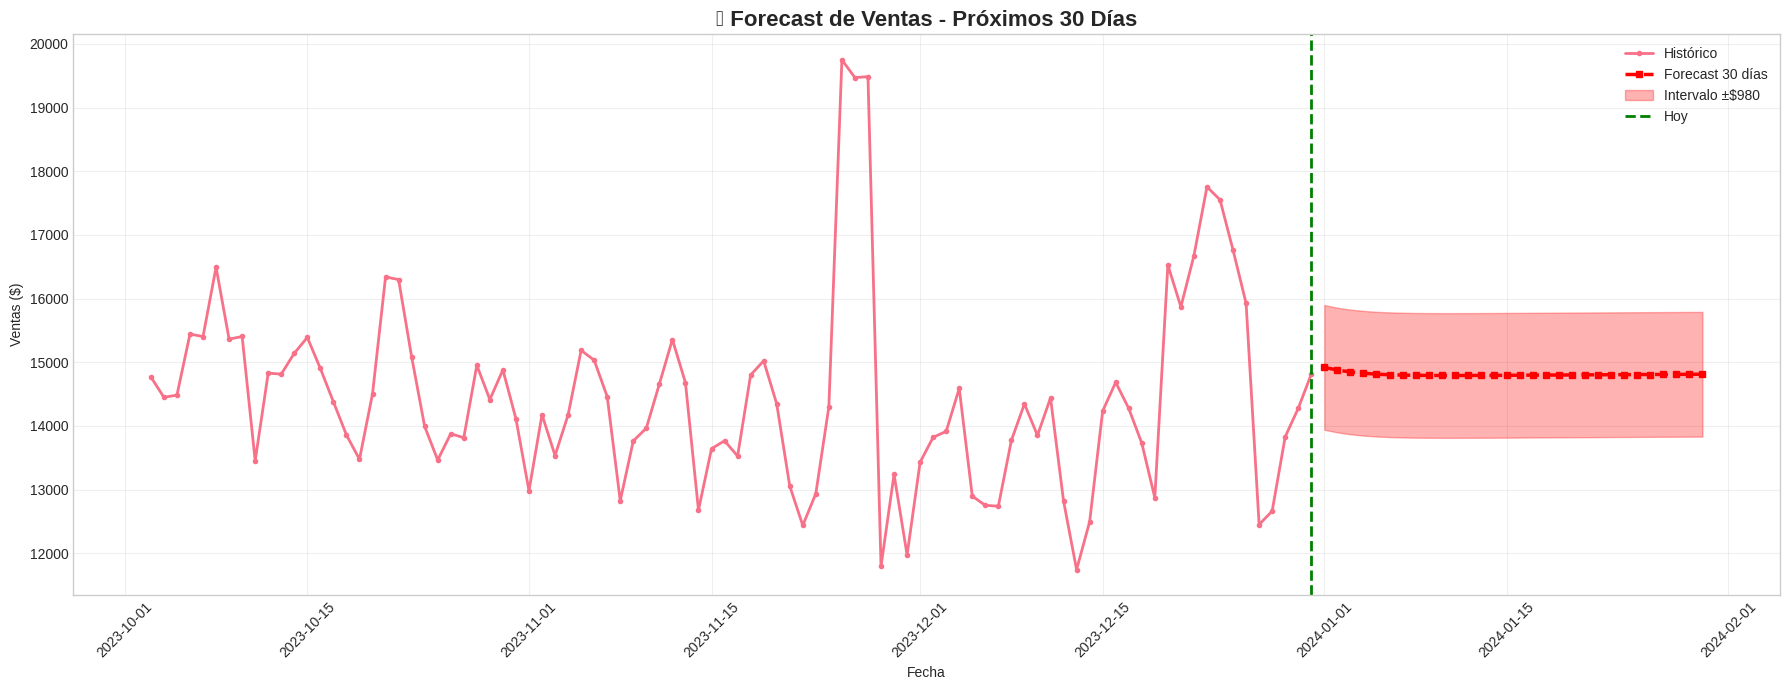


📊 Resumen del Forecast:
   • Ventas promedio estimadas: $14,809.08
   • Total estimado: $444,272.53


In [14]:
print("\n" + "=" * 80)
print("PASO 14: FORECASTING DE PRÓXIMOS 30 DÍAS")
print("=" * 80)

def forecast_futuro(model, last_sequence, scaler, n_days=30):
    predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(n_days):
        current_sequence_reshaped = current_sequence.reshape(1, LOOKBACK, 1)
        next_pred = model.predict(current_sequence_reshaped, verbose=0)[0, 0]
        predictions.append(next_pred)
        current_sequence = np.append(current_sequence[1:], next_pred)

    predictions = np.array(predictions).reshape(-1, 1)
    predictions = scaler.inverse_transform(predictions)

    return predictions

# Últimos 60 días
last_60_days = data_scaled[-LOOKBACK:, 0]

print("\n🔮 Prediciendo próximos 30 días...")
future_predictions = forecast_futuro(model, last_60_days, scaler, n_days=30)

# Fechas futuras
last_date = df['fecha'].iloc[-1]
future_dates = [last_date + timedelta(days=i+1) for i in range(30)]

# Visualizar
plt.figure(figsize=(18, 7))
plt.plot(df['fecha'].tail(90), df['ventas'].tail(90),
         label='Histórico', linewidth=2, marker='o', markersize=3)
plt.plot(future_dates, future_predictions,
         label='Forecast 30 días', linewidth=2.5,
         marker='s', markersize=5, color='red', linestyle='--')
plt.fill_between(future_dates,
                 future_predictions.flatten() - test_metrics[0],
                 future_predictions.flatten() + test_metrics[0],
                 alpha=0.3, color='red', label=f'Intervalo ±${test_metrics[0]:.0f}')
plt.axvline(x=last_date, color='green', linestyle='--', linewidth=2, label='Hoy')
plt.title('🔮 Forecast de Ventas - Próximos 30 Días', fontsize=16, fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('Ventas ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\n📊 Resumen del Forecast:")
print(f"   • Ventas promedio estimadas: ${future_predictions.mean():,.2f}")
print(f"   • Total estimado: ${future_predictions.sum():,.2f}")

---

## 🔧 PASO 15: Aplicaciones a marketing

In [15]:
print("\n" + "=" * 80)
print("💼 PASO 15: APLICACIONES A MARKETING")
print("=" * 80)

forecast_df = pd.DataFrame({
    'fecha': future_dates,
    'ventas_predichas': future_predictions.flatten()
})
forecast_df['dia_semana'] = forecast_df['fecha'].dt.day_name()

dias_ordenados = forecast_df.sort_values('ventas_predichas')

print("\n📉 Top 5 días con MENOR demanda (oportunidad para campaña):")
for idx, row in dias_ordenados.head(5).iterrows():
    print(f"   • {row['fecha'].strftime('%d/%m/%Y')} ({row['dia_semana']}): ${row['ventas_predichas']:,.2f}")

mejor_dia = dias_ordenados.iloc[0]
print(f"\n✨ RECOMENDACIÓN:")
print(f"   Lanzar campaña el {mejor_dia['fecha'].strftime('%d/%m/%Y')}")
print(f"   • Demanda base: ${mejor_dia['ventas_predichas']:,.2f}")
print(f"   • Potencial de uplift: Alto (valle de demanda)")


💼 PASO 15: APLICACIONES A MARKETING

📉 Top 5 días con MENOR demanda (oportunidad para campaña):
   • 11/01/2024 (Thursday): $14,791.20
   • 10/01/2024 (Wednesday): $14,791.23
   • 12/01/2024 (Friday): $14,791.64
   • 09/01/2024 (Tuesday): $14,791.98
   • 13/01/2024 (Saturday): $14,792.39

✨ RECOMENDACIÓN:
   Lanzar campaña el 11/01/2024
   • Demanda base: $14,791.20
   • Potencial de uplift: Alto (valle de demanda)


---

## 🔧 PASO 16: Guardar Modelo

In [16]:
print("\n" + "=" * 80)
print("PASO 16: GUARDAR MODELO")
print("=" * 80)

import pickle

model.save('lstm_sales_forecast.keras')
print("✅ Modelo guardado: lstm_sales_forecast.keras")

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("✅ Scaler guardado: scaler.pkl")


PASO 16: GUARDAR MODELO
✅ Modelo guardado: lstm_sales_forecast.keras
✅ Scaler guardado: scaler.pkl


---

## 🔧 PASO 17: Resumen final

In [17]:
print("\n" + "=" * 80)
print("🎓 RESUMEN Y APRENDIZAJES")
print("=" * 80)

print(f"""
✅ Caso práctico completado:
   • MAPE en Test: {test_metrics[2]:.2f}%
   • MAE: ${test_metrics[0]:,.2f}
   • Forecast 30 días: ✅
   • Modelo guardado: ✅

🎯 Has aprendido:
   1. Preparación de series temporales
   2. Arquitectura LSTM
   3. Normalización de datos
   4. Métricas de forecasting (MAPE, MAE, RMSE)
   5. Predicción futura
   6. Aplicaciones a marketing

🚀 Próximos pasos:
   • Añadir variables exógenas
   • Probar GRU
   • Comparar con ARIMA/Prophet
   • Dashboard interactivo

🎉 ¡CASO PRÁCTICO COMPLETADO!
""")


🎓 RESUMEN Y APRENDIZAJES

✅ Caso práctico completado:
   • MAPE en Test: 6.53%
   • MAE: $979.53
   • Forecast 30 días: ✅
   • Modelo guardado: ✅

🎯 Has aprendido:
   1. Preparación de series temporales
   2. Arquitectura LSTM
   3. Normalización de datos
   4. Métricas de forecasting (MAPE, MAE, RMSE)
   5. Predicción futura
   6. Aplicaciones a marketing

🚀 Próximos pasos:
   • Añadir variables exógenas
   • Probar GRU
   • Comparar con ARIMA/Prophet
   • Dashboard interactivo

🎉 ¡CASO PRÁCTICO COMPLETADO!

